In [0]:
import tensorflow as tf
print('Tensorflow version:',tf.__version__)
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Activation

Tensorflow version: 1.10.0


Using TensorFlow backend.


In [0]:
!git clone https://github.com/InFoCusp/tf_cnnvis.git

Cloning into 'tf_cnnvis'...
remote: Counting objects: 350, done.
remote: Total 350 (delta 0), reused 0 (delta 0), pack-reused 350
Receiving objects: 100% (350/350), 3.71 MiB | 27.56 MiB/s, done.
Resolving deltas: 100% (182/182), done.


In [0]:
!python tf_cnnvis/setup.py install
!python tf_cnnvis/setup.py clean

running install
running bdist_egg
running egg_info
creating tf_cnnvis.egg-info
writing tf_cnnvis.egg-info/PKG-INFO
writing dependency_links to tf_cnnvis.egg-info/dependency_links.txt
writing requirements to tf_cnnvis.egg-info/requires.txt
writing top-level names to tf_cnnvis.egg-info/top_level.txt
writing manifest file 'tf_cnnvis.egg-info/SOURCES.txt'
package init file 'tf_cnnvis/__init__.py' not found (or not a regular file)
reading manifest file 'tf_cnnvis.egg-info/SOURCES.txt'
writing manifest file 'tf_cnnvis.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/tf_cnnvis
copying tf_cnnvis/setup.py -> build/lib/tf_cnnvis
creating build/bdist.linux-x86_64
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/tf_cnnvis
copying build/lib/tf_cnnvis/setup.py -> build/bdist.linux-x86_64/egg/tf_cnnvis
byte-compiling build/bdist.linux-x86_64/egg/tf_cnnvis/s

In [0]:
import os
import sys
import copy
import h5py
from tf_cnnvis import *
from scipy.misc import imread, imresize

In [0]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [0]:
x_train = x_train.astype('float32')/max(x_train.flatten())
x_test = x_test.astype('float32')/max(x_train.flatten())
print('Pixel max:',max(x_train.flatten()),', Pixel min:',min(x_train.flatten()))

y_train_label = tf.keras.utils.to_categorical(y_train,10)
y_test_label = tf.keras.utils.to_categorical(y_test,10)
print('Train label shape:',y_train_label.shape,', Test label shape:',y_test_label.shape)

train_size = x_train.shape[0]
test_size = x_test.shape[0]
print('Train size:',train_size, ', Test size:',test_size)

x_train = x_train.reshape(train_size,28,28,1)
x_test = x_test.reshape(test_size,28,28,1)
print('Train data shape:', x_train.shape,', Test data shape:', x_test.shape)



Pixel max: 1.0 , Pixel min: 0.0
Train label shape: (60000, 10) , Test label shape: (10000, 10)
Train size: 60000 , Test size: 10000
Train data shape: (60000, 28, 28, 1) , Test data shape: (10000, 28, 28, 1)


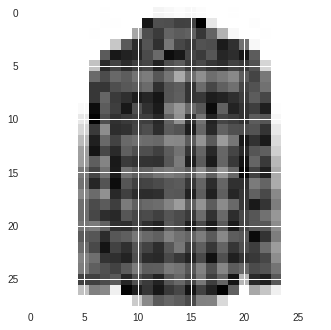

In [0]:
plt.imshow(x_train[np.random.randint(0,train_size)].reshape(28,28))

In [0]:
print(max(x_train.flatten()), y_train[:10], y_train_label[:10])

1.0 [9 0 0 3 0 2 7 2 5 5] [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


**Model training (Keras)**

**Building the model**

In [0]:
tf.keras.backend.clear_session()
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Input


model = Sequential()
model.add(Dense(10,input_shape=(28*28,),activation='softmax'))
#model.add(Dense(10,activation='softmax'))

model.compile(loss='categorical_crossentropy',
             optimizer='sgd',
             metrics=['accuracy'])

model.summary()
'''
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=4, padding='same', activation='relu', input_shape=(28,28,1))) 
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=4, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256,activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(10,activation='softmax'))
model.add(tf.keras.layers.Flatten())

model.summary()

# Compile the model
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])
'''
!rm -rf log

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


**Fitting the data**

In [0]:
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

batch_size = 100
epoch = 30

tfcb = tf.keras.callbacks.TensorBoard(log_dir='./log', histogram_freq=1,
                         write_graph=True,
                         write_grads=True,
                         batch_size=batch_size,
                         write_images=True)

modelckpt = ModelCheckpoint(filepath='./model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',period=1)

model.fit(x_train.reshape(train_size,28*28), y_train_label, epochs=epoch, batch_size=batch_size, validation_split=0.3, callbacks=[modelckpt])

Train on 42000 samples, validate on 18000 samples
Epoch 1/30
42000/42000 [==============================] - 1s 25us/step - loss: 1.2067 - acc: 0.6347 - val_loss: 0.8776 - val_acc: 0.7267

Epoch 00001: val_acc improved from -inf to 0.72667, saving model to ./model.hdf5
Epoch 2/30
42000/42000 [==============================] - 1s 23us/step - loss: 0.8045 - acc: 0.7476 - val_loss: 0.7464 - val_acc: 0.7672

Epoch 00002: val_acc improved from 0.72667 to 0.76722, saving model to ./model.hdf5
Epoch 3/30
42000/42000 [==============================] - 1s 20us/step - loss: 0.7127 - acc: 0.7743 - val_loss: 0.6820 - val_acc: 0.7817

Epoch 00003: val_acc improved from 0.76722 to 0.78172, saving model to ./model.hdf5
Epoch 4/30
42000/42000 [==============================] - 1s 20us/step - loss: 0.6630 - acc: 0.7884 - val_loss: 0.6447 - val_acc: 0.7916

Epoch 00004: val_acc improved from 0.78172 to 0.79161, saving model to ./model.hdf5
Epoch 5/30
42000/42000 [==============================] - 1s 20us

**get graph**

In [0]:
from keras import backend as K
tf_graph = K.get_session().graph
print(tf_graph)

**Model evaluation on test set**

In [0]:
y_test_label.shape

(10000, 10)

In [0]:
score = model.evaluate(x_test.reshape(-1,28*28), y_test_label, verbose=1)
print('Test loss:',score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 0s 14us/step
Test loss: 3.1743887393951415
Test accuracy: 0.7991


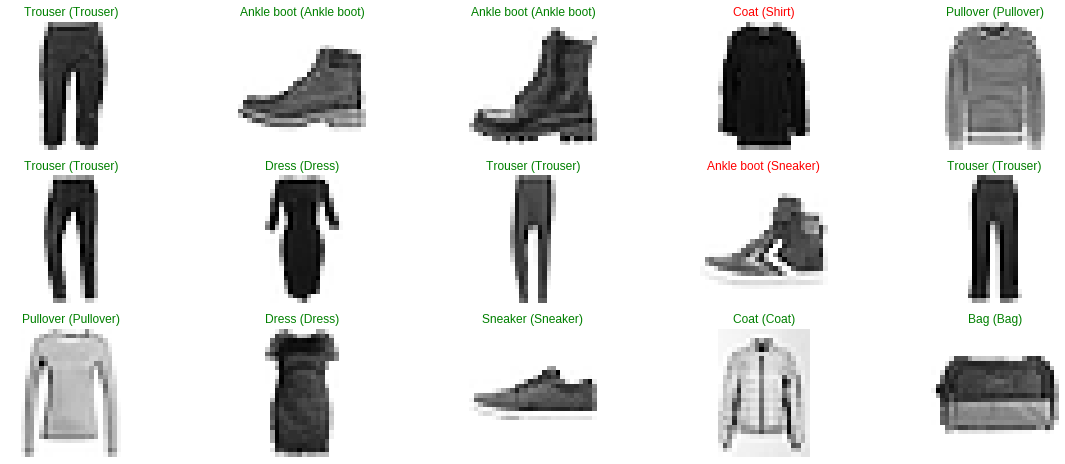

In [0]:
prediction = model.predict(x_test.reshape(-1,28*28))

fashion_mnist_labels = ["T-shirt/top", 
                            "Trouser",
                            "Pullover",
                            "Dress",
                            "Coat",
                            "Sandal", 
                            "Shirt",
                            "Sneaker",
                            "Bag",
                            "Ankle boot"]

figure = plt.figure(figsize=(20,8))

for i, index in enumerate(np.random.choice(x_test.shape[0], size=15, replace=False)):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
   
    ax.imshow(x_test[index].reshape(28,28))
    predict_index = np.argmax(prediction[index])
    true_index = np.argmax(y_test_label[index])
   
    ax.set_title("{} ({})".format(fashion_mnist_labels[predict_index], 
                                  fashion_mnist_labels[true_index]),
                                  color=("green" if predict_index == true_index else "red"))

**Model trainning (Raw TensorFlow)**

**Building the computational graph**

In [0]:
batch_size = 100
test_size = x_test.shape[0]

graph = tf.Graph()
with graph.as_default():
  
  tf_data = tf.placeholder(tf.float32, [batch_size, 28,28,1],name='data')
  tf_label = tf.placeholder(tf.float32, [batch_size, 10], name='label')
  keep_prob = tf.placeholder(tf.float32,name='kp')
  
  tf_test_data = tf.constant(x_test.reshape(-1,28,28,1))
  tf_test_label = tf.constant(y_test_label)
  
  
  filter = {
      'l1': tf.Variable( tf.random_normal([4,4,1,128]) ),
      'l2': tf.Variable( tf.random_normal([4,4,128,64]) )
  }
  
  dense = {
      'l1': tf.Variable( tf.random_normal([7*7*64,256]) ),
      'l2': tf.Variable( tf.random_normal([256,10]) )
  }
  
  
  bia = {
      'l1':tf.Variable( tf.random_normal([128]) ),
      'l2':tf.Variable( tf.random_normal([64]) ),
      'd1': tf.Variable( tf.random_normal([256]) ),
      'd2': tf.Variable( tf.random_normal([10]) )
  }
  
  w1 = tf.Variable( tf.random_normal([28*28,10]) )
  b1 = tf.Variable( tf.random_normal([10]) )
  
  def model(data):
    conv1 = tf.nn.conv2d(data, filter['l1'],strides=[1,1,1,1], padding='SAME')
    conv1 = tf.nn.max_pool(conv1, ksize=[1,2,2,1],strides=[1,2,2,1], padding='VALID')
    conv1 = tf.nn.relu(conv1 + bia['l1'])
    conv1 = tf.nn.dropout(conv1,0.3)
    
    conv2 = tf.nn.conv2d(conv1, filter['l2'],strides=[1,1,1,1], padding='SAME')
    conv2 = tf.nn.max_pool(conv2, ksize=[1,2,2,1],strides=[1,2,2,1], padding='VALID')
    conv2 = tf.nn.relu(conv2 + bia['l2'])
    conv2 = tf.nn.dropout(conv2,0.3)
    flatten = tf.reshape(conv2,shape=(tf.shape(conv2)[0],7*7*64))
    
    dense1 = tf.matmul(flatten,dense['l1']) + bia['d1']
    dense1 = tf.nn.relu(dense1)
    dense1 = tf.nn.dropout(dense1,0.5)
    
    dense2 = tf.matmul(dense1,dense['l2']) + bia['d2']
    #dense2 = tf.nn.relu(dense2)
    #output = tf.nn.dropout(dense2,0.5)
    
    return dense2
  
  
  def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

  def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)
  
  def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

  def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')
  


  
  
  def lin_model(data):
    """
    output = tf.matmul(tf.reshape(data,shape=(-1,28*28)),w1) + b1
    """
    W_conv1 = weight_variable([5, 5, 1, 32])
    b_conv1 = bias_variable([32])
  
    h_conv1 = tf.nn.relu(conv2d(data, W_conv1) + b_conv1)
    h_pool1 = max_pool_2x2(h_conv1)
    
    W_conv2 = weight_variable([5, 5, 32, 64])
    b_conv2 = bias_variable([64])
    
    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
    h_pool2 = max_pool_2x2(h_conv2)
   
    
    W_fc1 = weight_variable([7 * 7 * 64, 1024])
    b_fc1 = bias_variable([1024])

    h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
    
    
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
    
    W_fc2 = weight_variable([1024, 10])
    b_fc2 = bias_variable([10])

    y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
    output = y_conv
    
    return output
  
  
    
  logit = lin_model(tf_data)
  
  #loss = tf.reduce_mean(-tf.reduce_sum(tf_label * tf.log(logit), reduction_indices=[1]))
  loss = tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf_label, logits=logit))
  
  #optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  optimizer = tf.train.AdamOptimizer(1e-4).minimize(loss) 
  
  train_pred = tf.nn.softmax(lin_model(tf_data))
  
  hi = lin_model(tf_test_data)
  test_pred = tf.nn.softmax(hi)
  
  train_correct_prediction = tf.equal(tf.argmax(train_pred,1), tf.argmax(tf_label,1))
  train_accuracy = tf.reduce_mean(tf.cast(train_correct_prediction, tf.float32))
  
  test_correct_prediction = tf.equal(tf.argmax(test_pred,1), tf.argmax(tf_test_label,1))
  test_accuracy = tf.reduce_mean(tf.cast(test_correct_prediction, tf.float32))
  
  print('Graph built')
  
print('Batch size:', batch_size) 
  
  

Graph built
Batch size: 100


**Creating a session**

In [0]:
num_step = 1000000

result = []


with tf.Session(graph=graph) as session:
  session.run(tf.global_variables_initializer())
  for k in range(num_step):
    ls = np.random.choice(train_size,batch_size,replace=False)
    feed_dicta = {tf_data: x_train[ls].astype(np.float32), tf_label: y_train_label[ls].astype(np.float32), keep_prob: 1.0}

    _, l, test_acc, train_acc,test_prediction, hihi = session.run([optimizer, loss, test_accuracy, train_accuracy, test_pred, hi], feed_dict=feed_dict)
    result.append(test_acc)
    if k%10 == 0:
      print('Step',k)
      print('Loss:',l)
      print('Mini batch accuracy:', train_acc)
      print('Test accuracy:',test_acc)
      print('logit:',hihi[0])
  
    

Step 0
Loss: 8.630236
Mini batch accuracy: 0.04
Test accuracy: 0.0023
logit: [  311.48642    476.46744   -443.40176    -38.060913  1076.5221
   -80.88305     29.886042  -300.5021    -249.66116  -1045.4125  ]
Step 10
Loss: 2.6082265
Mini batch accuracy: 0.08
Test accuracy: 0.0023
logit: [  311.48642    476.46744   -443.40176    -38.060913  1076.5221
   -80.88305     29.886042  -300.5021    -249.66116  -1045.4125  ]
Step 20
Loss: 1.5486072
Mini batch accuracy: 0.06
Test accuracy: 0.0023
logit: [  311.48642    476.46744   -443.40176    -38.060913  1076.5221
   -80.88305     29.886042  -300.5021    -249.66116  -1045.4125  ]
Step 30
Loss: 1.0320598
Mini batch accuracy: 0.08
Test accuracy: 0.0023
logit: [  311.48642    476.46744   -443.40176    -38.060913  1076.5221
   -80.88305     29.886042  -300.5021    -249.66116  -1045.4125  ]


KeyboardInterrupt: ignored

In [0]:
a = "A"
print(type(ord(a)))

<class 'int'>


In [0]:
y_train_label.dtype

dtype('float32')

**Plotting accuracy**

In [0]:
plt.plot(result)

NameError: ignored

**Tensorboard**

In [0]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

--2018-07-31 14:58:05--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 54.152.208.69, 54.164.206.44, 52.86.186.182, ...
Connecting to bin.equinox.io (bin.equinox.io)|54.152.208.69|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5363700 (5.1M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.1’

ngrok-stable-linux- 100%[===================>]   5.11M  7.68MB/s    in 0.7s    

2018-07-31 14:58:06 (7.68 MB/s) - ‘ngrok-stable-linux-amd64.zip.1’ saved [5363700/5363700]

Archive:  ngrok-stable-linux-amd64.zip
replace ngrok? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [0]:
!y

In [0]:
LOG_DIR = './log'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [0]:
get_ipython().system_raw('./ngrok http 6006 &')

In [0]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"                                                                                                                                                                                                                                       

http://1f0a602f.ngrok.io


In [0]:
ls

datalab/  log/  ngrok*  ngrok-stable-linux-amd64.zip


In [0]:
from google.colab import files

In [0]:
hi = files.upload()

In [0]:
!pwd

/content


In [0]:
!cd datalab

In [0]:
ls

datalab/  log/


In [0]:
rm -rf log ngrok-stable-linux-amd64.zip.1

In [0]:
from google.colab import files
files.download('model.hdf5')

In [0]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
import tensorflow as tf
sess = tf.InteractiveSession()
x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])
W = tf.Variable(tf.zeros([784,10]))
b = tf.Variable(tf.zeros([10]))
sess.run(tf.global_variables_initializer())
y = tf.matmul(x,W) + b
cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)
for _ in range(1000):
  batch = mnist.train.next_batch(100)
  train_step.run(feed_dict={x: batch[0], y_: batch[1]})


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py fr

In [0]:
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print(accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels}))

def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)
def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])
x_image = tf.reshape(x, [-1, 28, 28, 1])
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  for i in range(20000):
    batch = mnist.train.next_batch(50)
    if i % 100 == 0:
      train_accuracy = accuracy.eval(feed_dict={
          x: batch[0], y_: batch[1], keep_prob: 1.0})
      print('step %d, training accuracy %g' % (i, train_accuracy))
      print('cross entropy %g' % cross_entropy.eval(feed_dict={
          x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))
    train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

  print('test accuracy %g' % accuracy.eval(feed_dict={
      x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))

In [0]:
batch_size = 100
test_size = x_test.shape[0]

graph2 = tf.Graph()
with graph2.as_default():
  
  tf_data = tf.placeholder(tf.float32, [batch_size, 28,28,1],name='data')
  tf_label = tf.placeholder(tf.float32, [batch_size, 10], name='label')
  keep_prob = tf.placeholder(tf.float32,name='kp')
  
  tf_test_data = tf.constant(x_test.reshape(-1,28,28,1))
  tf_test_label = tf.constant(y_test_label)
  
  
  def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

  def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)
  
  def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

  def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

  
  def model(x):
    W_conv1 = weight_variable([5, 5, 1, 32])
    b_conv1 = bias_variable([32])
    x_image = tf.reshape(x, [-1, 28, 28, 1])
    
    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
    h_pool1 = max_pool_2x2(h_conv1)
    W_conv2 = weight_variable([5, 5, 32, 64])
    b_conv2 = bias_variable([64])

    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
    h_pool2 = max_pool_2x2(h_conv2)
    W_fc1 = weight_variable([7 * 7 * 64, 1024])
    b_fc1 = bias_variable([1024])

    h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
    keep_prob = tf.placeholder(tf.float32)
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
    W_fc2 = weight_variable([1024, 10])
    b_fc2 = bias_variable([10])

    y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
    
    return y_conv
  
  
  def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

  def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)
  
  def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

  def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')
  


  
  
  def lin_model(data):
    """
    output = tf.matmul(tf.reshape(data,shape=(-1,28*28)),w1) + b1
    """
    W_conv1 = weight_variable([5, 5, 1, 32])
    b_conv1 = bias_variable([32])
  
    h_conv1 = tf.nn.relu(conv2d(data, W_conv1) + b_conv1)
    h_pool1 = max_pool_2x2(h_conv1)
    
    W_conv2 = weight_variable([5, 5, 32, 64])
    b_conv2 = bias_variable([64])
    
    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
    h_pool2 = max_pool_2x2(h_conv2)
   
    
    W_fc1 = weight_variable([7 * 7 * 64, 1024])
    b_fc1 = bias_variable([1024])

    h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
    
    
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
    
    W_fc2 = weight_variable([1024, 10])
    b_fc2 = bias_variable([10])

    y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
    output = y_conv
    
    return output
  
  
    
  logit = lin_model(tf_data)
  
  #loss = tf.reduce_mean(-tf.reduce_sum(tf_label * tf.log(logit), reduction_indices=[1]))
  loss = tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf_label, logits=logit))
  
  #optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  optimizer = tf.train.AdamOptimizer(1e-4).minimize(loss) 
  
  train_pred = tf.nn.softmax(lin_model(tf_data))
  
  hi = lin_model(tf_test_data)
  test_pred = tf.nn.softmax(hi)
  
  train_correct_prediction = tf.equal(tf.argmax(train_pred,1), tf.argmax(tf_label,1))
  train_accuracy = tf.reduce_mean(tf.cast(train_correct_prediction, tf.float32))
  
  test_correct_prediction = tf.equal(tf.argmax(test_pred,1), tf.argmax(tf_test_label,1))
  test_accuracy = tf.reduce_mean(tf.cast(test_correct_prediction, tf.float32))
  
  print('Graph built')
  
print('Batch size:', batch_size) 
  
  

In [0]:
a = 5
b = 5
if b>= a:
  print("h")

h


In [0]:
import random
if random.randint(0, 1) == 2:
  print("h")